# Face Detector - Image Classification Training Notebook

This notebook is used for training an EfficientNet model for classifying a human face, a human finger and a background image. This was created for demo purposes where a user testing the model can use a webcam, hence the choices of classed *(finger, face and background/nothing)*.

This notebook requires TensorFlow 2.11.X.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys; sys.path.append(os.path.dirname(os.getcwd()))
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import shutil

print(f"TensorFlow version: {tf.__version__}")

2023-10-22 18:26:18.765850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 18:26:19.535379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-22 18:26:19.535437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-22 18:26:19.535446: W tensorfl

TensorFlow version: 2.11.1


## Extract Training and Test Data
This extracts training and validation data from data.zip and extracts test data from test.zip onto /data and /test respectively.

In [2]:
# Download training dataset from S3 bucket
# import boto3

# def download_S3(object_key, destination):
#     # Set up the S3 client
#     s3 = boto3.client('s3',
#                   endpoint_url=os.getenv("AWS_S3_ENDPOINT"),
#                   aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
#                   aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

#     # Specify the bucket name and object (file) key
#     bucket_name = os.getenv("AWS_S3_BUCKET")

#     # Download the file from S3
#     try:
#         s3.download_file(bucket_name, object_key, destination)
#         print(f'Successfully downloaded file from S3: {object_key}')
#     except Exception as e:
#         print(f'Error: {e}')


# download_S3('dataset/data.zip', 'data.zip')
# download_S3('dataset/test.zip', 'test.zip')

print(os.getcwd())

data_path = './data/'
compressed_data_path = './data.zip'
test_data_path = './test/'
compressed_test_data_path = './test.zip'


def extract_zip(compressed_path, dest_path):
    # Check if the folder exists
    if os.path.exists(dest_path):
        # Use shutil.rmtree() to delete the folder and its contents
        shutil.rmtree(dest_path)
        print(f"The folder '{dest_path}' has been deleted.")
    else:
        print(f"The folder '{dest_path}' does not exist.")

    with zipfile.ZipFile(compressed_path, 'r') as zip_ref:
        zip_ref.extractall(dest_path)

    print(f"The file {compressed_path} was extracted to {dest_path}")


extract_zip(compressed_data_path, data_path)
extract_zip(compressed_test_data_path, test_data_path)

/opt/app-root/src/MLOps-with-Red-Hat-OpenShift/chapter8/training
The folder './data/' has been deleted.
The file ./data.zip was extracted to ./data/
The folder './test/' has been deleted.
The file ./test.zip was extracted to ./test/


## Prepare Dataset

This step prepares the training and validation datasets. The images in ./data is split into two groups "training" and "validation" where 20% of the images is used in the "validation" group.

In [3]:
image_size = (256, 256)
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="rgb"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="rgb"
)

NUM_CLASSES = len(train_ds.class_names)

Found 56 files belonging to 3 classes.
Using 45 files for training.
Found 56 files belonging to 3 classes.
Using 11 files for validation.


2023-10-22 18:26:20.434638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-22 18:26:20.434669: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-22 18:26:20.434691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (face-detection-0): /proc/driver/nvidia/version does not exist
2023-10-22 18:26:20.434947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preview Training Dataset

Verify that we have correctly loaded the images into the training dataset **train_ds**.

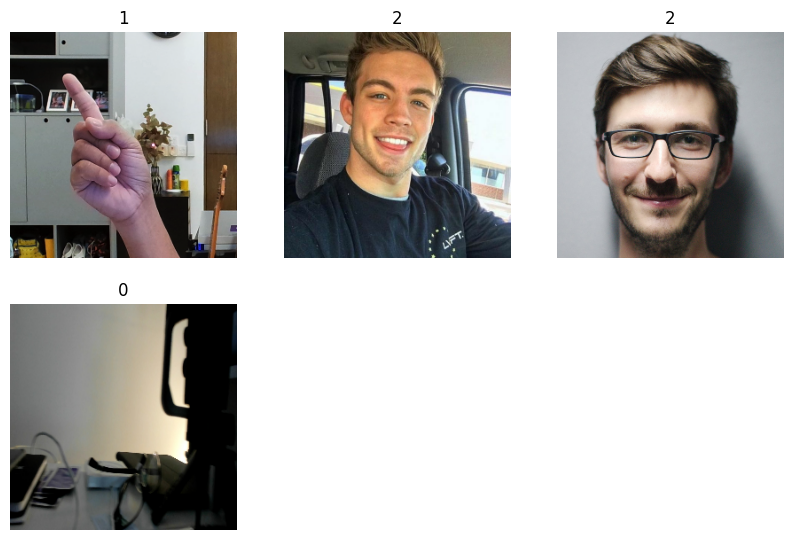

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation
Enrich the training data by providing flipped and rotated version of the images.

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down overfitting.

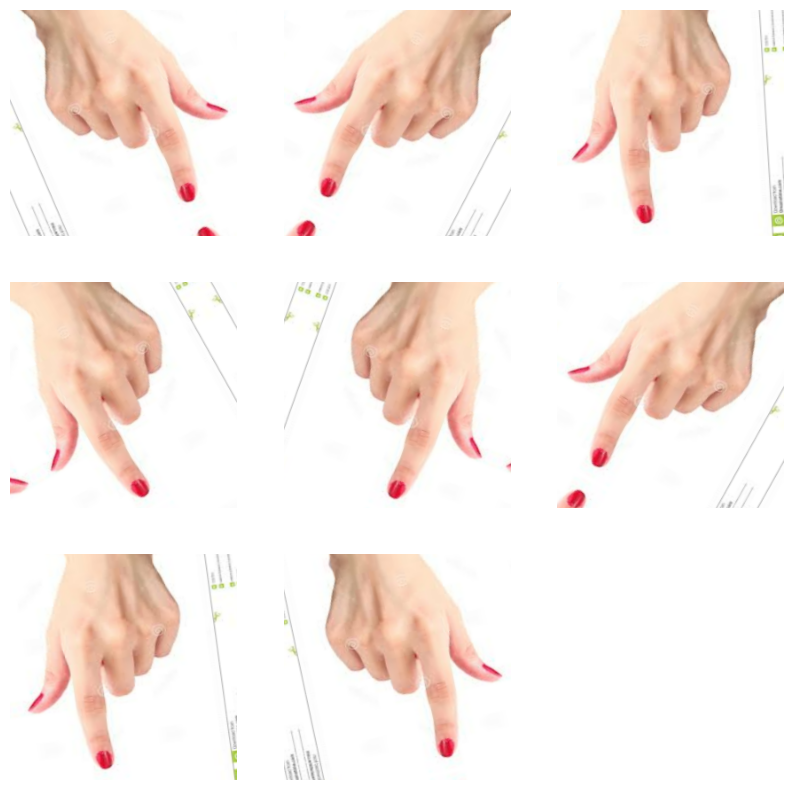

In [5]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# Visualize augmented data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Optimize Dataset Performance

Ensure the use buffered prefetching and pre-processing so to reduce disk I/O operations during training.
This is particularly important for large datasets.

In [6]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(input_preprocess)

## Configure the Model Architecture

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:
- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We also include a `Dropout` layer before the final classification layer.

Note: You may optionally visualize the resulting model architecture by adding the following line of code. This requires pydot which you can install by running the command: `!pip install pydot`

`keras.utils.plot_model(model, show_shapes=True)`

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    model = EfficientNetV2B0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = True

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=NUM_CLASSES)

## Model Training

This compiles the model and starts the model training process.
You can play around with the parameters such as the number of epochs and the optimizer used.

In [8]:
epochs = 10
save_best = tf.keras.callbacks.ModelCheckpoint(
    "../deploy/model.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",

)
callbacks = [
    save_best,
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

model.save("face-detector-model.h5")

Epoch 1/10
12/12 [==============================] - 21s 419ms/step - loss: 1.1187 - accuracy: 0.5333 - val_loss: 0.4619 - val_accuracy: 0.8182
Epoch 2/10
12/12 [==============================] - 3s 256ms/step - loss: 1.2494 - accuracy: 0.7111 - val_loss: 0.5825 - val_accuracy: 0.7273
Epoch 3/10
12/12 [==============================] - 3s 260ms/step - loss: 0.5474 - accuracy: 0.7778 - val_loss: 0.4718 - val_accuracy: 0.7273
Epoch 4/10
12/12 [==============================] - 4s 305ms/step - loss: 0.8260 - accuracy: 0.8444 - val_loss: 0.4132 - val_accuracy: 0.8182
Epoch 5/10
12/12 [==============================] - 4s 308ms/step - loss: 0.4388 - accuracy: 0.8889 - val_loss: 0.1696 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 4s 308ms/step - loss: 0.5525 - accuracy: 0.8222 - val_loss: 0.1532 - val_accuracy: 0.9091
Epoch 7/10
12/12 [==============================] - 3s 258ms/step - loss: 1.1205 - accuracy: 0.8000 - val_loss: 0.9481 - val_accuracy: 0.8182
Epoch

## Testing

Now that we have a model, lest use it to perform some inferences. There `/test` directory contains images that we will use to test.

This step will go run a prediction for each of the images in the `/test` directory. 
The files are named according to their classes. Verify if the filenames and the predictions are matching.

In [9]:
# Inference

import numpy as np

def get_class(score):
    number = np.argmax(score)
    words = ["Background", "Finger", "Face"]
    if 0 <= number <= 2:
        return words[number]
    else:
        return "Invalid input"


for filename in os.listdir(test_data_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Do something with the file (for example, print the file name)
        print(f"test for --> {filename}")

        img = keras.preprocessing.image.load_img(
            test_data_path+filename, target_size=image_size, color_mode="rgb"
        )

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]

        print(score)
        print("prediction --> " + get_class(score))
        print("#####################################\n")

test for --> face1.jpg
1/1 [==============================] - 1s 935ms/step
[0.04915201 0.00226556 0.94858235]
prediction --> Face
#####################################

test for --> background.png
1/1 [==============================] - 0s 31ms/step
[0.13931383 0.85378885 0.00689725]
prediction --> Finger
#####################################

test for --> face2.jpg
1/1 [==============================] - 0s 32ms/step
[7.7638641e-04 1.4309643e-03 9.9779260e-01]
prediction --> Face
#####################################

test for --> finger.png
1/1 [==============================] - 0s 32ms/step
[0.00314482 0.9939028  0.00295243]
prediction --> Finger
#####################################

